# GEOL 7720 - Exercise 9
#### December 18 2017

#### Ian Deniset 

## Problem
Apply non-linear inversion methods to a set of DC resistivity measurements to calculate layer resistivity and thickness.

## Theory
Due to the fact that electrical current paths are controlled by the resistivity structure of the subsurface, DC resistivity measurements are non-linear in nature.  Thus, in order to invert for subsurface properties such as layer resistivity and thickness, non-linear inversion methods need to be applied.  Two common approaches are a grid search and a Monte Carlo search.

### Grid Search:
In a grid search, each model parameter is given a range of plausible values forming a multi-dimension grid of all possible parameter combinations.  The misfit for each point is then calculated by comparing the observed data to the predicted data.  The combination that provides the lowest misfit can be considered the 'best' model; this is best observed by plotting the misfit surface when the problem is two dimensional. 

### Monte Carlo Search:
A Monte Carlo search is similar to a grid search in the fact that combinations of model parameters bounded by acceptable limits are compared to the true data, with the lowest misfit giving the 'best' model.  However, unlike the systematic approach used in a grid search, the model values tested with the Monte Carlo method are randomly generated between the specified bounds.  

## Solution
Using a function that calculates the apparent resistivity for a two layer structure using a given set of electrode spacings, a grid and Monte Carlo search will be performed to obtain subsurface properties for a set of resistivity measurements.

In [1]:
#import usual modules 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

Define the function for calculating the predicted apparent resistivities for a two layer subsurface at a specified electrode spacing:

In [2]:
#Modified MATLAB function

# rho_a=wenner_2lay(a,rho_1,rho_2)
# gives the apparent resistivity returned by a Wenner array over a
# two-layer structure with resistivities rho_1, rho_2 and upper-layer
# thickness z. a should contain a vector of electrode spacings.
#
# Notation is from Telford et al., _Applied Geophysics_

def wenner_2lay(a,rho_1,rho_2,z):

    num_terms=40; # number of terms for summation. Increasing this improves accuracy.

    k=(rho_2-rho_1)/(rho_2+rho_1);
    z_sc=np.divide(z,a); # scale layer thickness by electrode spacing

    Dw=np.zeros(len(a));
    
    for m in np.arange(1,num_terms,1): #m=1:num_terms:
        Dw = Dw+k**m * ((1+(2*m*z_sc)**2)**(-0.5) - (4+(2*m*z_sc)**2)**(-0.5));

    return(rho_1*(1+4*Dw))

Load in the observed data and electrode spacing:

In [3]:
#original data vectors
elecSpacing = np.asarray([1,2,4,8,10,20,40,80,100,200])
print(elecSpacing)
resObs = np.asarray([40.9,37.9,42.7,45.5,44.1,67.0,103.8,149.8,166.9,210.6])
print(resObs)

[  1   2   4   8  10  20  40  80 100 200]
[  40.9   37.9   42.7   45.5   44.1   67.   103.8  149.8  166.9  210.6]


Plot the observed data:

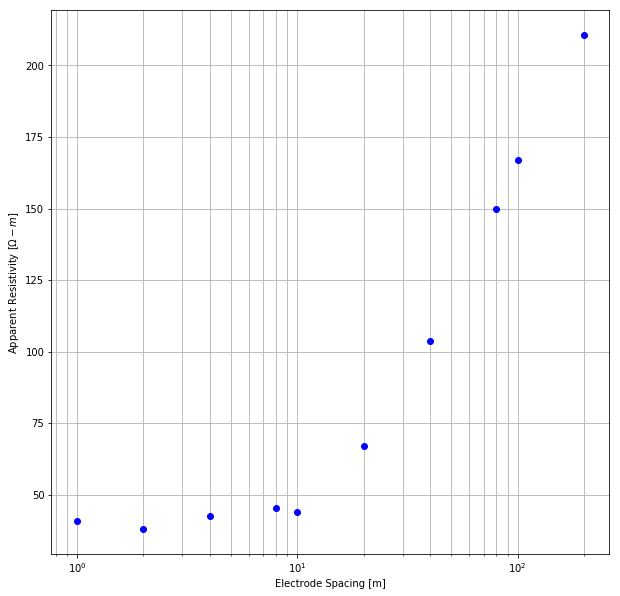

In [4]:
#plot the original data
fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(elecSpacing, resObs, c='b')
ax.set_xscale('log')
ax.set_ylabel('Apparent Resistivity [$\Omega - m$]')
ax.set_xlabel('Electrode Spacing [m]')
ax.grid(which='both')
ax.set_axisbelow(True)

plt.show()

### Grid Search
Looking at the original observed data above, it can be seen that the first 5 observations at close electrode spacings are relatively consistent at around $40 \Omega - m$ and can thus be taken as the resistivity of the upper most layer.  Using this value as a constant, a two dimensional grid search will be performed to obtain the remaining upper layer thickness and lower layer resistivity.

In [5]:
###grid search parameters 
thickMin = 5.0   #min upper layer thickness
thickMax = 20.0  #max upper layer thickness
depthStep = 0.25 #sample step for the upper layer thickness
rho2Min = 150.0  #min lower layer resistivity
rho2Max = 300.0  #max lower layer resistivity
rho2Step = 1.0   #sample step for the lower layer resistivity 
rho1 = 40.0      #upper layer resistivity; constant

#calculate the search grid dimensions
reshapeGS = [len(np.arange(thickMin, thickMax, depthStep)),len(np.arange(rho2Min, rho2Max, rho2Step))]
print('The dimensions of the search grid are: ', reshapeGS)

The dimensions of the search grid are:  [60, 150]


In [6]:
#empty lists for calculated values
l2normGS = []
l1normGS = []
thickness = []
rho2 = []

#loop over search grid and calculate both L1 and L2 norms
for z in np.arange(thickMin, thickMax, depthStep):
    for r in np.arange(rho2Min, rho2Max, rho2Step):
        thickness.append(z)
        rho2.append(r)
        predicted = wenner_2lay(elecSpacing, rho1, r, z)
        
        #calculate l2 norm for current grid search values; append to array
        l2normGS.append((np.sum((resObs-predicted)**2)/len(resObs))**(1/2))
        
        #calculate l1 norm for current grid search values; append to array
        l1normGS.append((1/len(resObs))*np.sum(np.abs(resObs-predicted)))

Plot the calculated misfit surfaces for both the L1 and L2 norms along with associated best fit model value:

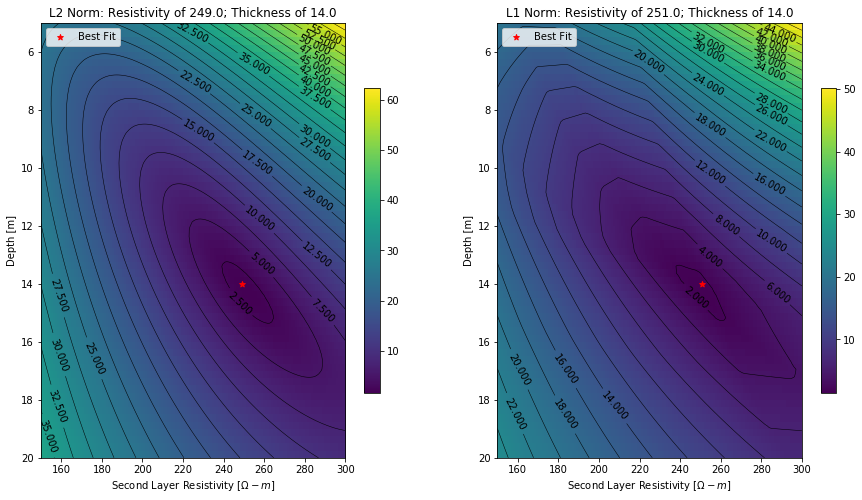

In [7]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

####l2 Norm
iml2 = ax[0].imshow(np.reshape(l2normGS,(reshapeGS)), aspect='auto', interpolation='none', 
               extent=[rho2Min, rho2Max, thickMax, thickMin])
csl2 = ax[0].contour(np.reshape(l2normGS,(reshapeGS)), 25, colors='k', linewidths=0.5,
               extent=[rho2Min, rho2Max, thickMin, thickMax])
ax[0].clabel(csl2, inline=1, fontsize=10)
ax[0].scatter(rho2[np.argmin(l2normGS)], thickness[np.argmin(l2normGS)], c='r', marker='*',
          label='Best Fit')
ax[0].set_ylabel('Depth [m]')
ax[0].set_xlabel('Second Layer Resistivity [$\Omega -m$]')
ax[0].set_title('L2 Norm: Resistivity of %.1f; Thickness of %.1f' %(rho2[np.argmin(l2normGS)],
                                                                 thickness[np.argmin(l2normGS)]))
fig.colorbar(iml2, ax = ax[0], shrink=0.7)
ax[0].legend(loc='upper left')

####l1 Norm
iml1 = ax[1].imshow(np.reshape(l1normGS,(reshapeGS)), aspect='auto', interpolation='none', 
               extent=[rho2Min, rho2Max, thickMax, thickMin])
csl1 = ax[1].contour(np.reshape(l1normGS,(reshapeGS)), 25, colors='k', linewidths=0.5,
               extent=[rho2Min, rho2Max, thickMin, thickMax])
ax[1].clabel(csl1, inline=1, fontsize=10)
ax[1].scatter(rho2[np.argmin(l1normGS)], thickness[np.argmin(l1normGS)], c='r', marker='*',
          label='Best Fit')
ax[1].set_ylabel('Depth [m]')
ax[1].set_xlabel('Second Layer Resistivity [$\Omega -m$]')
ax[1].set_title('L1 Norm: Resistivity of %.1f; Thickness of %.1f' %(rho2[np.argmin(l1normGS)],
                                                                 thickness[np.argmin(l1normGS)]))

fig.colorbar(iml1, ax = ax[1], shrink=0.7)
ax[1].legend(loc='upper left')


plt.show()

#### Comments:
As can be seen in the above two plots, both misfit surfaces provide a unique minimum norm solution for the specified range of model parameters.  For the L2 norm, the best fit model parameters are an upper layer thickness of 14 m and a lower layer resistivity of 249 $\Omega-m$.  For the L1 norm, the best fit model also has an upper layer thickness of 14 m, however, the lower layer resistivity is found to be 251 $\Omega -m$.

Also of interest is the shape of the misfit surfaces themselves.  Looking at a singular contour value shows that a larger range of depth values produce a given misfit in comparison to the range of resistivity values that provide the same misfit.  The relation is what gives the contours their elliptical shape.

### Monte Carlo

Using the same set of observed values and electrode spacings, the subsurface model will now be obtained using the Monte Carlo method.  For this inversion, the resistivity of the upper layer will also be allowed to vary, giving a total of three model parameters being solved for.  Values obtained for the best fit model using the grid search method above will be used to guide the model parameter range. 

In [8]:
###Monte Carlo search parameters
thickMax_MC = 20.0      #max upper layer thickness
thickMin_MC = 12.0      #min upper layer thickness
rho1Max_MC = 47.0       #max upper layer resistivity
rho1Min_MC = 35.0       #min upper layer resistivity
rho2Max_MC = 280.0      #max lower layer resistivity
rho2Min_MC = 220.0      #min lower layer resistivity

#number of random models to generate 
numModels = 5000

In [9]:
#empty lists to hold calculated values
thickness_MC = []
rho1_MC = []
rho2_MC = []
l2normMC = []
l1normMC = []
apparentResMC =[]

#run specified number of random models and calculate both L2 and L1 norms
for i in range(numModels):
    #generate random numbers for 3 parameters
    thick_i = (thickMax_MC-thickMin_MC)*np.random.rand()+thickMin_MC
    thickness_MC.append(thick_i)
    
    rho1_i = (rho1Max_MC-rho1Min_MC)*np.random.rand()+rho1Min_MC
    rho1_MC.append(rho1_i)
    
    rho2_i = (rho2Max_MC-rho2Min_MC)*np.random.rand()+rho2Min_MC
    rho2_MC.append(rho2_i)
    
    ###calculate predicted data using random parameters above
    predictedMC = wenner_2lay(elecSpacing, rho1_i, rho2_i, thick_i)
    apparentResMC.append(predictedMC)
        
    #calculate l2 norm for current model values; append to array
    l2normMC.append((np.sum((resObs-predictedMC)**2/len(resObs))**(1/2)))
    
    #calculate l1 norm for current model values; append to array
    l1normMC.append((1/len(resObs))*np.sum(np.abs(resObs-predictedMC)))

#### L2 Best Fit Model Parameters:

In [10]:
print('Layer 1 resistivity best fit: ', rho1_MC[np.argmin(l2normMC)])
print('Layer 2 resistivity best fit: ', rho2_MC[np.argmin(l2normMC)])
print('Layer 1 thickness best fit: ', thickness_MC[np.argmin(l2normMC)])

Layer 1 resistivity best fit:  40.771122057983774
Layer 2 resistivity best fit:  250.4478027423037
Layer 1 thickness best fit:  14.32097942919501


#### L1 Best Fit Model Parameters:

In [11]:
print('Layer 1 resistivity best fit: ', rho1_MC[np.argmin(l1normMC)])
print('Layer 2 resistivity best fit: ', rho2_MC[np.argmin(l1normMC)])
print('Layer 1 thickness best fit: ', thickness_MC[np.argmin(l1normMC)])

Layer 1 resistivity best fit:  40.771122057983774
Layer 2 resistivity best fit:  250.4478027423037
Layer 1 thickness best fit:  14.32097942919501


### Model Parameters Within Acceptable Error:
For the given accuracy of $\pm 2.5 \Omega -m$ on each measurement of the observed data, the expected misfit of both the L1 and L2 nomrs will be 2.5.  Using this value, it can be said that any model with parameter values that give a misfit of 2.5 or less can be deemed 'acceptable'.  

##### Run through the calculated model norms and select the model parameters that give the expected value or lower (2.5):
From the above 5000 models, only those with a misfit of 2.5 or less will be selected.  From those, the minimum and maximum value for each parameter will be found to give the range of acceptable values.

In [12]:
#obtain indices for misfit values <= 2.5
l2_withinErrorIx = np.asarray(np.where(np.asarray(l2normMC) <= 2.5))
l1_withinErrorIx = np.asarray(np.where(np.asarray(l1normMC) <= 2.5))

In [13]:
###append misfit <= 2.5 model parameters values to lists

rho1withinError_l1 = []
rho2withinError_l1 = []
thickwithinError_l1 = []
l1_withinError = []

rho1withinError_l2 = []
rho2withinError_l2 = []
thickwithinError_l2 = []
l2_withinError = []

for i in range(len(l1_withinErrorIx[0])):
    rho1withinError_l1.append(rho1_MC[l1_withinErrorIx[0,i]])
    rho2withinError_l1.append(rho2_MC[l1_withinErrorIx[0,i]])
    thickwithinError_l1.append(thickness_MC[l1_withinErrorIx[0,i]])
    l1_withinError.append(l1normMC[l1_withinErrorIx[0,i]])
    
for i in range(len(l2_withinErrorIx[0])):    
    rho1withinError_l2.append(rho1_MC[l2_withinErrorIx[0,i]])
    rho2withinError_l2.append(rho2_MC[l2_withinErrorIx[0,i]])
    thickwithinError_l2.append(thickness_MC[l2_withinErrorIx[0,i]])
    l2_withinError.append(l2normMC[l2_withinErrorIx[0,i]])

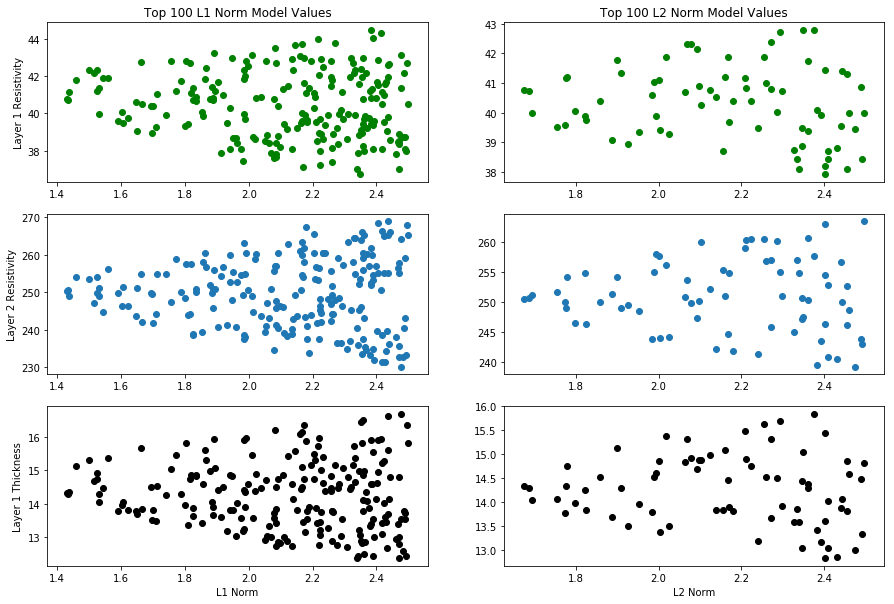

In [14]:
#plot the parameters for models with a misfit of 2.5 or less
fig, ax = plt.subplots(3,2, figsize=(15,10))

ax[0,0].scatter(l1_withinError,  rho1withinError_l1, c='g')
ax[0,0].set_ylabel('Layer 1 Resistivity')
ax[0,0].set_title('Top 100 L1 Norm Model Values')
ax[0,1].scatter(l2_withinError, rho1withinError_l2, c='g')
ax[0,1].set_title('Top 100 L2 Norm Model Values')
ax[1,0].scatter(l1_withinError, rho2withinError_l1)
ax[1,0].set_ylabel('Layer 2 Resistivity')
ax[1,1].scatter(l2_withinError, rho2withinError_l2)
ax[2,0].scatter(l1_withinError, thickwithinError_l1, c='k')
ax[2,0].set_ylabel('Layer 1 Thickness')
ax[2,0].set_xlabel('L1 Norm')
ax[2,1].scatter(l2_withinError, thickwithinError_l2, c='k')
ax[2,1].set_xlabel('L2 Norm')


plt.show()

#### Actual Bounding Values:
The following are the minimum and maximum parameter values within the acceptable misfit value (2.5 or less):

In [15]:
#print out the max/min values that provide values within the expected error (2.5)
print('The maximum and minimum resistivity values of the first layer for the L1 norm are: ', np.amax(rho1withinError_l1),
      'and', np.amin(rho1withinError_l1))
print('The maximum and minimum resistivity values of the second layer for the L1 norm are: ', np.amax(rho2withinError_l1),
      'and', np.amin(rho2withinError_l1))
print('The maximum and minimum thickness of the first layer for the L1 norm are: ', np.amax(thickwithinError_l1),
      'and', np.amin(thickwithinError_l1))

print('\nThe maximum and minimum resistivity values of the first layer for the L2 norm are: ', np.amax(rho1withinError_l2),
      'and', np.amin(rho1withinError_l2))
print('The maximum and minimum resistivity values of the second layer for the L2 norm are: ', np.amax(rho2withinError_l2),
      'and', np.amin(rho2withinError_l2))
print('The maximum and minimum thickness of the first layer for the L2 norm are: ', np.amax(thickwithinError_l2),
      'and', np.amin(thickwithinError_l2))

The maximum and minimum resistivity values of the first layer for the L1 norm are:  44.4649615247 and 36.7459801913
The maximum and minimum resistivity values of the second layer for the L1 norm are:  268.940797271 and 230.235080618
The maximum and minimum thickness of the first layer for the L1 norm are:  16.6854651015 and 12.3745195515

The maximum and minimum resistivity values of the first layer for the L2 norm are:  42.7937968084 and 37.9155472287
The maximum and minimum resistivity values of the second layer for the L2 norm are:  263.366394845 and 239.242008559
The maximum and minimum thickness of the first layer for the L2 norm are:  15.8238440994 and 12.8319431687


#### Visualizing the acceptable value range:
Below are plots for the L1 and L2 norm acceptable parameter values.  Just like the grid search method, a skew is evident with a larger spread on the depth values and a tighter grouping for the resistivity values. 

<IPython.core.display.Javascript object>


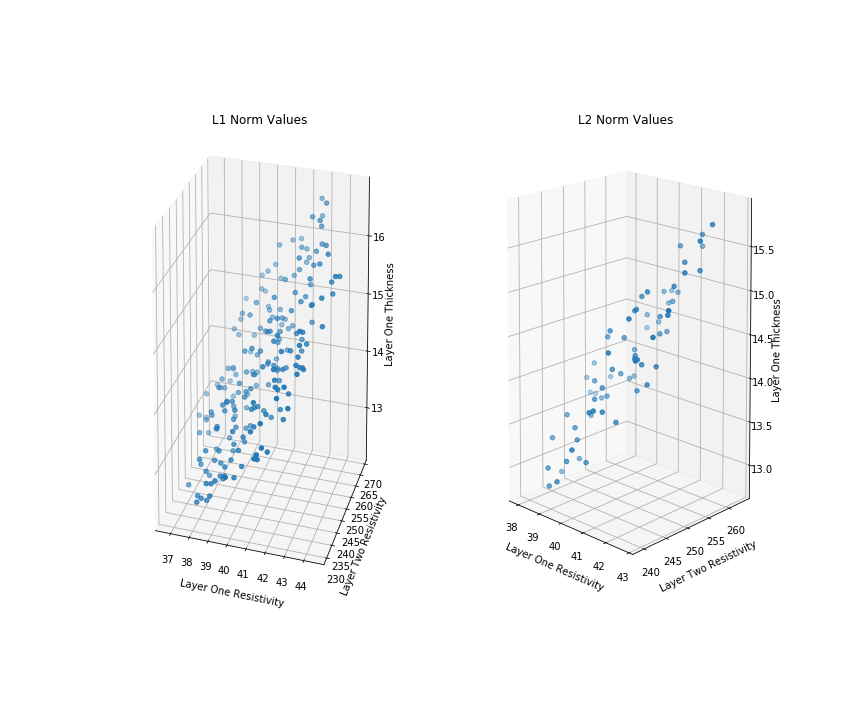

In [18]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
%matplotlib notebook

fig, ax = plt.subplots(1,2, figsize=(12,10), subplot_kw={'projection': '3d'})
ax[0].scatter(rho1withinError_l1, rho2withinError_l1, thickwithinError_l1)
ax[0].set_xlabel('Layer One Resistivity')
ax[0].set_ylabel('Layer Two Resistivity')
ax[0].set_zlabel('Layer One Thickness')
ax[0].set_title('L1 Norm Values')

ax[1].scatter(rho1withinError_l2, rho2withinError_l2, thickwithinError_l2)
ax[1].set_xlabel('Layer One Resistivity')
ax[1].set_ylabel('Layer Two Resistivity')
ax[1].set_zlabel('Layer One Thickness')
ax[1].set_title('L2 Norm Values')

plt.show()